In [1]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
# Load the dataset
biomass_data = pd.read_csv('site_data.csv')

# Transpose the DataFrame to have products as rows and locations as columns
data_transposed = biomass_data.set_index(['dataset', 'site_name', 'site_id', 'X', 'Y']).T

# Remove non-numeric rows
data_transposed_numeric = data_transposed.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop columns with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(axis=1, how='all')

# Impute missing values with column mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
data_imputed = data_transposed_numeric.fillna(data_transposed_numeric.mean())

In [3]:
# Perform kmeans clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed.T)

# You may need to adjust the number of clusters based on your data and analysis goals
# ‘ward’ minimizes the variance of the clusters being merged.
n_clusters = 5
cluster = KMeans(n_clusters=n_clusters)
clusters = cluster.fit_predict(data_scaled)

# Add cluster labels to the transposed DataFrame
#PRESENTATION USED DATA THAT WASN'T IMPUTED WITH MEANS, THUS CLUSTERS AND INDICES VALUES ARE DIFFERENT
data_transposed_numeric.loc['cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_numeric.T.reset_index()

In [9]:
biomass_data_clustered

,dataset,site_name,site_id,X,Y,ESA CCI,Chopping et al.,GEDI L4B,Liu et al.,LT-GNN,Menlove & Healey,Xu et al.,cluster
0,NEON,Harvard Forest,HARV,-72.17266,42.53690,NaN,NaN,164.080719,37.921211,NaN,114.922806,NaN,1.0
1,NEON,Smithsonian Conservation Biology Institute,SCBI,-78.13950,38.89292,NaN,NaN,334.279755,115.212837,NaN,106.782768,NaN,3.0
2,NEON,Ordway-Swisher Biological Station,OSBS,-81.99343,29.68927,NaN,NaN,63.379155,69.890287,NaN,42.734001,NaN,4.0
3,NEON,UNDERC,UNDE,-89.53725,46.23388,NaN,NaN,155.069643,139.331772,NaN,91.699257,NaN,1.0
4,NEON,Konza Prairie Biological Station,KONZ,-96.56309,39.10077,NaN,NaN,7.477551,10.838812,NaN,10.135107,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,Ameriflux,NEON University of Notre Dame Environmental Re...,US-xUN,-89.53730,46.23390,NaN,NaN,155.035292,139.331772,NaN,91.699257,NaN,1.0
493,Ameriflux,NEON Woodworth (WOOD),US-xWD,-99.24140,47.12820,NaN,NaN,4.150213,9.719900,NaN,0.000000,NaN,0.0
494,Ameriflux,NEON Wind River Experimental Forest (WREF),US-xWR,-121.95190,45.82050,244.415145,NaN,357.726868,194.783264,NaN,320.595123,819.682068,2.0
495,Ameriflux,NEON Yellowstone Northern Range (Frog Rock) (Y...,US-xYE,-110.53910,44.95350,7.986143,NaN,37.207724,59.854660,NaN,36.563770,79.867683,4.0


In [4]:
# Save the clustering results to a CSV file
biomass_data_clustered.to_csv('clustering_product_kmeans5.csv', index=False)

In [5]:
# Convert the data to a DataFrame
df = pd.DataFrame(biomass_data_clustered)

# List of products
products = ['ESA CCI', 'Chopping et al.', 'GEDI L4B', 'Liu et al.', 'LT-GNN', 'Menlove & Healey', 'Xu et al.']

# Create a DataFrame for the heatmap data
heatmap_data = pd.DataFrame(index=products, columns=df['cluster'].unique())

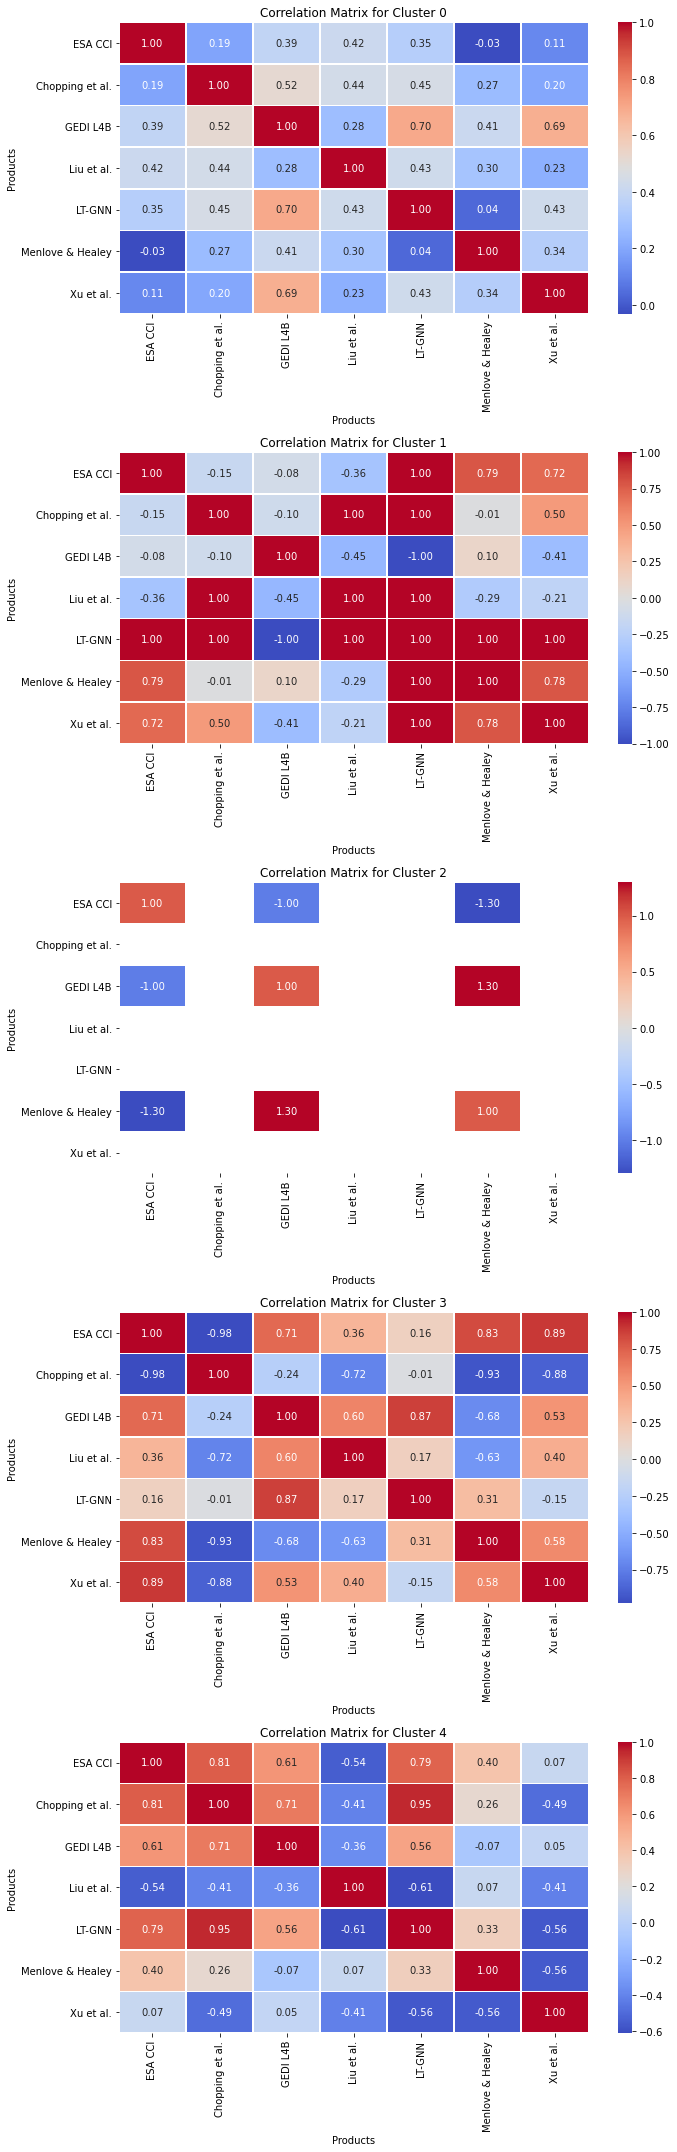

In [6]:
# Group data by cluster
grouped = df.groupby('cluster')

# Create subplots for each cluster
fig, axes = plt.subplots(len(grouped), 1, figsize=(10, 6 * len(grouped)))

# Calculate correlations and plot heatmaps for each cluster
for i, (cluster, data) in enumerate(grouped):
    corr_matrix = data[products].corr()
    sns.heatmap(corr_matrix, ax=axes[i], cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
    axes[i].set_title(f'Correlation Matrix for Cluster {int(cluster)}')
    axes[i].set_xlabel('Products')
    axes[i].set_ylabel('Products')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

# Assuming 'data' is your DataFrame with the clustering results
# Replace 'cluster_results.csv' with the path to your clustering results file
# data = pd.read_csv('cluster_results.csv')
data = biomass_data_clustered

# Extract predicted cluster labels
predicted_labels = data['cluster']

# Evaluate clustering performance using Silhouette Coefficient
# The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. 
# Scores around zero indicate overlapping clusters.
# The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster
silhouette_score_value = silhouette_score(data_scaled, predicted_labels)
print(f"Silhouette Coefficient: {silhouette_score_value}")

# Evaluate clustering performance using Calinski-Harabasz Index
# Variance Ratio Criterion - can be used to evaluate the model, 
# where a higher Calinski-Harabasz score relates to a model with better defined clusters
calinski_harabasz_score_value = calinski_harabasz_score(data_scaled, predicted_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz_score_value}")

# Evaluate clustering performance using Davies-Bouldin Index
# This index signifies the average ‘similarity’ between clusters,
# where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
davies_bouldin_score_value = davies_bouldin_score(data_scaled, predicted_labels)
print(f"Davies-Bouldin Index: {davies_bouldin_score_value}")

Silhouette Coefficient: 0.5607328591656706
Calinski-Harabasz Index: 679.4956536952064
Davies-Bouldin Index: 0.8551760920856865
